In [54]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(42)

In [130]:
import PIL

def monoImageLoader(path):
    with open(path, 'rb') as f:
        img = PIL.Image.open(f)
        return img.convert("L")
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

dataset = torchvision.datasets.ImageFolder(root = '/data/datasets/fonts/rendered/numbers_small',
                                           loader = monoImageLoader,
                                           transform = transform)
loader = torch.utils.data.DataLoader(
dataset, batch_size=200, shuffle=True,num_workers=10)

print("Classes:", dataset.classes)

dataiter = iter(loader)
images, labels = dataiter.next()
print("Batch shape:", images.size())
print("Labels:", labels)
for p in net.parameters():
    print(p.size(), p.numel())
print("Trainable parameters:", sum([p.numel() for p in net.parameters()]))

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Batch shape: torch.Size([200, 1, 25, 25])
Labels: tensor([0, 2, 1, 9, 5, 2, 2, 8, 8, 5, 5, 3, 5, 8, 4, 8, 7, 0, 5, 2, 9, 7, 4, 8,
        5, 9, 9, 1, 3, 4, 8, 5, 9, 1, 4, 3, 8, 7, 9, 3, 0, 0, 3, 1, 9, 0, 8, 6,
        5, 3, 8, 4, 9, 7, 3, 4, 7, 3, 1, 9, 2, 6, 2, 3, 9, 8, 6, 0, 7, 4, 1, 4,
        0, 4, 6, 2, 2, 4, 6, 1, 8, 2, 4, 6, 4, 2, 2, 1, 8, 0, 7, 9, 0, 9, 4, 7,
        3, 0, 0, 8, 6, 8, 4, 4, 3, 2, 3, 6, 5, 4, 5, 9, 4, 3, 5, 7, 4, 8, 5, 1,
        0, 4, 6, 1, 3, 4, 2, 4, 7, 7, 7, 3, 7, 7, 1, 7, 2, 9, 7, 5, 2, 6, 0, 5,
        7, 7, 4, 5, 1, 6, 9, 8, 6, 0, 3, 2, 2, 5, 6, 2, 5, 3, 2, 0, 4, 6, 7, 5,
        7, 0, 1, 0, 5, 1, 9, 7, 4, 9, 5, 2, 3, 2, 7, 3, 3, 7, 4, 5, 7, 9, 1, 4,
        2, 0, 9, 9, 4, 4, 9, 2])
torch.Size([6, 1, 3, 3]) 54
torch.Size([6]) 6
torch.Size([16, 6, 3, 3]) 864
torch.Size([16]) 16
torch.Size([120, 256]) 30720
torch.Size([120]) 120
torch.Size([84, 120]) 10080
torch.Size([84]) 84
torch.Size([10, 84]) 8

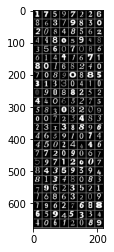

In [106]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [107]:
n = images[0].numpy()
print(n.min(), n.max())

-1.0 1.0


In [126]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
net = Net()
n = net(images)
print(n.shape)

torch.Size([200, 10])


In [127]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  net = nn.DataParallel(net)

net.to(device)

Let's use 2 GPUs!


DataParallel(
  (module): Net(
    (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (fc1): Linear(in_features=256, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [128]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(comment="tutorial")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)

step = 0
for epoch in range(1):
    
    total = 0
    correct = 0
    running_loss = 0.0
    for i, data in enumerate(loader):
        step += 1
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = correct / total
        
        writer.add_scalar("Loss/train", loss.item(), step)
        writer.add_scalar("Accuracy/train", accuracy, step)
        
        running_loss += loss.item()
        if i % 200 == 199:
            print(f"[Epoch {epoch:02d} Minibatch {i:06d}] loss: {running_loss / 200}. Accuracy {correct} / {total} ({(accuracy)*100:0.2f})")
            running_loss = 0.0
            total = 0
            correct = 0
            
            # Log some sample images
            writer.add_images("Images/train", data[0], step)

            
print("Finished training!")

[Epoch 00 Minibatch 000199] loss: 2.287648766040802. Accuracy 9205 / 40000 (23.01)
[Epoch 00 Minibatch 000399] loss: 2.1011801052093504. Accuracy 17865 / 40000 (44.66)
[Epoch 00 Minibatch 000599] loss: 0.9457850004732609. Accuracy 31422 / 40000 (78.55)
[Epoch 00 Minibatch 000799] loss: 0.40960498608648777. Accuracy 35584 / 40000 (88.96)
[Epoch 00 Minibatch 000999] loss: 0.2852593170851469. Accuracy 36801 / 40000 (92.00)
[Epoch 00 Minibatch 001199] loss: 0.2105326549336314. Accuracy 37625 / 40000 (94.06)
[Epoch 00 Minibatch 001399] loss: 0.1679855730757117. Accuracy 38099 / 40000 (95.25)
[Epoch 00 Minibatch 001599] loss: 0.13886906674131752. Accuracy 38419 / 40000 (96.05)
[Epoch 00 Minibatch 001799] loss: 0.11734179645776749. Accuracy 38643 / 40000 (96.61)
[Epoch 00 Minibatch 001999] loss: 0.10279028018936515. Accuracy 38796 / 40000 (96.99)
[Epoch 00 Minibatch 002199] loss: 0.09782618638128042. Accuracy 38877 / 40000 (97.19)
[Epoch 00 Minibatch 002399] loss: 0.08232588100247085. Accurac

In [98]:
PATH = "tutorial.pth"
torch.save(net.state_dict(), PATH)